In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from factor_analyzer import Rotator
from sklearn.preprocessing import StandardScaler
import umap
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix

In [2]:
# load ivs_df from pkl
ivs_df = pd.read_pickle("../data/ivs_df.pkl")
variable_view = pd.read_pickle("../data/variable_view.pkl")

In [3]:
ivs_df.head()

,studyno,version,doi,stdyno_w,versn_w,S001,s002,S002EVS,s002vs,S003,...,Y022B,Y022C,Y023,Y023A,Y023B,Y023C,Y024,Y024A,Y024B,Y024C
0,4001.0,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,1562.0,WVS7 v.5.0,2.0,7.0,NaN,7.0,20.0,...,0.66,0.66,0.296296,0.333333,0.111111,0.444444,0.000,0.00,0.0,0.000
1,4001.0,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,1562.0,WVS7 v.5.0,2.0,7.0,NaN,7.0,20.0,...,0.66,0.66,0.888889,0.888889,0.888889,0.888889,0.500,1.00,0.0,0.500
2,4001.0,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,1562.0,WVS7 v.5.0,2.0,7.0,NaN,7.0,20.0,...,0.66,0.66,0.666667,1.000000,0.444444,0.555556,0.415,0.33,0.5,0.415
3,4001.0,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,1562.0,WVS7 v.5.0,2.0,7.0,NaN,7.0,20.0,...,1.00,1.00,0.592593,0.555556,0.333333,0.888889,0.415,0.33,0.5,0.415
4,4001.0,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,1562.0,WVS7 v.5.0,2.0,7.0,NaN,7.0,20.0,...,0.66,0.66,0.629630,0.777778,0.444444,0.666667,0.250,0.00,0.5,0.250


In [4]:
variable_view

,Name,Type,Width,Label,Missing,Measure,Align
0,studyno,Numeric,10,Study number,None,nominal,unknown
1,version,String,26,Version,None,nominal,unknown
2,doi,String,26,Digital Object Identifier,None,nominal,unknown
3,stdyno_w,Numeric,10,Study number (wave),None,nominal,unknown
4,versn_w,String,90,Version (wave),None,nominal,unknown
...,...,...,...,...,...,...,...
833,Y023C,Numeric,8,DIVORLIB- Welzel choice-3: Divorce acceptable,None,scale,unknown
834,Y024,Numeric,8,VOICE.- Welzel voice sub-index,None,scale,unknown
835,Y024A,Numeric,8,VOICE1- Welzel voice-1,None,scale,unknown
836,Y024B,Numeric,8,VOICE2- Welzel voice-2,None,scale,unknown


We need to filter down to the three most recent survey waves (from 2005 onwards). The most recent survey waves provide up-to-date information on cultural values, ensuring that the analysis reflects current societal norms and attitudes. We also filter out the ten questions from the IVS that form the basis of the Inglehart-Welzel Cultural Map. 

In [5]:
# Metadata we need
meta_col = ["S020", "S003"]
# Weights
weights = ["S017"]
# Use the ten questions from the IVS that form the basis of the Inglehart-Welzel Cultural Map
iv_qns = ["A008", "A165", "E018", "E025", "F063", "F118", "F120", "G006", "Y002", "Y003"]

In [6]:
subset_ivs_df = ivs_df[meta_col+weights+iv_qns]
subset_ivs_df

,S020,S003,S017,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003
0,2018.0,20.0,1.000000,1.0,2.0,1.0,2.0,7.0,4.0,2.0,NaN,1.0,0.0
1,2018.0,20.0,1.000000,1.0,2.0,1.0,1.0,1.0,9.0,9.0,1.0,3.0,-1.0
2,2018.0,20.0,1.000000,2.0,2.0,1.0,1.0,8.0,10.0,5.0,3.0,2.0,2.0
3,2018.0,20.0,1.000000,2.0,2.0,2.0,2.0,1.0,6.0,4.0,NaN,2.0,0.0
4,2018.0,20.0,1.000000,2.0,2.0,2.0,1.0,4.0,8.0,5.0,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
666902,2008.0,915.0,0.782164,2.0,1.0,1.0,2.0,10.0,2.0,1.0,NaN,2.0,-3.0
666903,2008.0,915.0,0.887335,3.0,1.0,1.0,2.0,10.0,1.0,1.0,NaN,2.0,-3.0
666904,2008.0,915.0,0.782164,2.0,2.0,1.0,1.0,10.0,7.0,5.0,NaN,2.0,-3.0
666905,2008.0,915.0,1.201044,1.0,2.0,1.0,1.0,10.0,1.0,1.0,NaN,2.0,-3.0


In [7]:
subset_ivs_df.describe()

,S020,S003,S017,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003
count,666907.000000,666907.000000,666907.000000,653006.000000,640372.000000,624982.000000,606033.000000,633123.000000,606363.000000,629651.000000,634203.000000,625175.000000,654446.000000
mean,2005.453414,448.674458,0.999952,1.931601,1.716619,1.542968,2.061936,7.141333,3.592447,3.827039,1.591057,1.800662,-0.990749
std,10.481040,257.830151,0.434010,0.726013,0.450640,0.733853,0.821852,3.219945,3.266736,3.011018,0.758780,0.626261,1.730594
min,1981.000000,8.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-3.000000
25%,1998.000000,231.000000,0.878843,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,-3.000000
50%,2007.000000,428.000000,1.000000,2.000000,2.000000,1.000000,2.000000,8.000000,1.000000,3.000000,1.000000,2.000000,-1.000000
75%,2014.000000,703.000000,1.000000,2.000000,2.000000,2.000000,3.000000,10.000000,6.000000,6.000000,2.000000,2.000000,0.000000
max,2023.000000,915.000000,32.250881,4.000000,2.000000,3.000000,3.000000,10.000000,10.000000,10.000000,4.000000,3.000000,2.000000


In [8]:
subset_ivs_df.isna().sum()

S020        0
S003        0
S017        0
A008    13901
A165    26535
E018    41925
E025    60874
F063    33784
F118    60544
F120    37256
G006    32704
Y002    41732
Y003    12461
dtype: int64

In [9]:
subset_ivs_df = subset_ivs_df.rename(columns={'S020': 'year', 'S003': 'country_code', 'S017': 'weight'})

In [10]:
subset_ivs_df

,year,country_code,weight,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003
0,2018.0,20.0,1.000000,1.0,2.0,1.0,2.0,7.0,4.0,2.0,NaN,1.0,0.0
1,2018.0,20.0,1.000000,1.0,2.0,1.0,1.0,1.0,9.0,9.0,1.0,3.0,-1.0
2,2018.0,20.0,1.000000,2.0,2.0,1.0,1.0,8.0,10.0,5.0,3.0,2.0,2.0
3,2018.0,20.0,1.000000,2.0,2.0,2.0,2.0,1.0,6.0,4.0,NaN,2.0,0.0
4,2018.0,20.0,1.000000,2.0,2.0,2.0,1.0,4.0,8.0,5.0,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
666902,2008.0,915.0,0.782164,2.0,1.0,1.0,2.0,10.0,2.0,1.0,NaN,2.0,-3.0
666903,2008.0,915.0,0.887335,3.0,1.0,1.0,2.0,10.0,1.0,1.0,NaN,2.0,-3.0
666904,2008.0,915.0,0.782164,2.0,2.0,1.0,1.0,10.0,7.0,5.0,NaN,2.0,-3.0
666905,2008.0,915.0,1.201044,1.0,2.0,1.0,1.0,10.0,1.0,1.0,NaN,2.0,-3.0


In [11]:
# remove before 2005
subset_ivs_df = subset_ivs_df[subset_ivs_df["year"] >= 2005]

In [12]:
subset_ivs_df.head()

,year,country_code,weight,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003
0,2018.0,20.0,1.0,1.0,2.0,1.0,2.0,7.0,4.0,2.0,NaN,1.0,0.0
1,2018.0,20.0,1.0,1.0,2.0,1.0,1.0,1.0,9.0,9.0,1.0,3.0,-1.0
2,2018.0,20.0,1.0,2.0,2.0,1.0,1.0,8.0,10.0,5.0,3.0,2.0,2.0
3,2018.0,20.0,1.0,2.0,2.0,2.0,2.0,1.0,6.0,4.0,NaN,2.0,0.0
4,2018.0,20.0,1.0,2.0,2.0,2.0,1.0,4.0,8.0,5.0,NaN,1.0,1.0


In [13]:
len(subset_ivs_df["country_code"].unique())

112

In [14]:
len(subset_ivs_df)

394524

The joint IVS data, after filtering, covers 394,524 individual-level survey response observations from 112 countries.

# Country Names and Metadata

We also need to collect the country names and metadata for the countries in our dataset. We will use this information to map the countries to their respective cultural regions and to identify Islamic countries.

In [15]:
data = {
    "Country": ["Afghanistan", "Albania", "Algeria", "American Samoa", "Andorra", "Angola", "Anguilla", 
                "Antarctica", "Antigua and Barbuda", "Argentina", "Armenia", "Aruba", "Australia", "Austria", 
                "Azerbaijan", "Bahamas (the)", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", 
                "Belize", "Benin", "Bermuda", "Bhutan", "Bolivia (Plurinational State of)", 
                "Bonaire, Sint Eustatius and Saba", "Bosnia and Herzegovina", "Botswana", "Bouvet Island", 
                "Brazil", "British Indian Ocean Territory (the)", "Brunei Darussalam", "Bulgaria", 
                "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Cayman Islands (the)", 
                "Central African Republic (the)", "Chad", "Chile", "China", "Christmas Island", 
                "Cocos (Keeling) Islands (the)", "Colombia", "Comoros (the)", "Congo (the Democratic Republic of the)", 
                "Congo (the)", "Cook Islands (the)", "Costa Rica", "Croatia", "Cuba", "Curaçao", "Cyprus", 
                "Czechia", "Côte d'Ivoire", "Denmark", "Djibouti", "Dominica", "Dominican Republic (the)", 
                "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", 
                "Ethiopia", "Falkland Islands (the) [Malvinas]", "Faroe Islands (the)", "Fiji", "Finland", 
                "France", "French Guiana", "French Polynesia", "French Southern Territories (the)", "Gabon", 
                "Gambia (the)", "Georgia", "Germany", "Ghana", "Gibraltar", "Greece", "Greenland", "Grenada", 
                "Guadeloupe", "Guam", "Guatemala", "Guernsey", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", 
                "Heard Island and McDonald Islands", "Holy See (the)", "Honduras", "Hong Kong", "Hungary", "Iceland", 
                "India", "Indonesia", "Iran (Islamic Republic of)", "Iraq", "Ireland", "Isle of Man", "Israel", 
                "Italy", "Jamaica", "Japan", "Jersey", "Jordan", "Kazakhstan", "Kenya", "Kiribati", 
                "Korea (the Democratic People's Republic of)", "Korea (the Republic of)", "Kuwait", "Kyrgyzstan", 
                "Lao People's Democratic Republic (the)", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", 
                "Liechtenstein", "Lithuania", "Luxembourg", "Macao", "Madagascar", "Malawi", "Malaysia", "Maldives", 
                "Mali", "Malta", "Marshall Islands (the)", "Martinique", "Mauritania", "Mauritius", "Mayotte", 
                "Mexico", "Micronesia (Federated States of)", "Moldova (the Republic of)", "Monaco", "Mongolia", 
                "Montenegro", "Montserrat", "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", 
                "Netherlands (the)", "New Caledonia", "New Zealand", "Nicaragua", "Niger (the)", "Nigeria", 
                "Niue", "Norfolk Island", "Northern Mariana Islands (the)", "Norway", "Oman", "Pakistan", "Palau", 
                "Palestine, State of", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines (the)", 
                "Pitcairn", "Poland", "Portugal", "Puerto Rico", "Qatar", "Republic of North Macedonia", "Romania", 
                "Russian Federation (the)", "Rwanda", "Réunion", "Saint Barthélemy", 
                "Saint Helena, Ascension and Tristan da Cunha", "Saint Kitts and Nevis", "Saint Lucia", 
                "Saint Martin (French part)", "Saint Pierre and Miquelon", "Saint Vincent and the Grenadines", "Samoa", 
                "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", 
                "Sierra Leone", "Singapore", "Sint Maarten (Dutch part)", "Slovakia", "Slovenia", "Solomon Islands", 
                "Somalia", "South Africa", "South Georgia and the South Sandwich Islands", "South Sudan", "Spain", 
                "Sri Lanka", "Sudan (the)", "Suriname", "Svalbard and Jan Mayen", "Sweden", "Switzerland", 
                "Syrian Arab Republic", "Taiwan (Province of China)", "Tajikistan", "Tanzania, United Republic of", 
                "Thailand", "Timor-Leste", "Togo", "Tokelau", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", 
                "Turkmenistan", "Turks and Caicos Islands (the)", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates (the)", 
                "United Kingdom of Great Britain and Northern Ireland (the)", "United States Minor Outlying Islands (the)", 
                "United States of America (the)", "Uruguay", "Uzbekistan", "Vanuatu", "Venezuela (Bolivarian Republic of)", 
                "Viet Nam", "Virgin Islands (British)", "Virgin Islands (U.S.)", "Wallis and Futuna", "Western Sahara", 
                "Yemen", "Zambia", "Zimbabwe", "Åland Islands"],
    "Numeric": [4, 8, 12, 16, 20, 24, 660, 10, 28, 32, 51, 533, 36, 40, 31, 44, 48, 50, 52, 112, 56, 84, 204, 60, 64, 
                68, 535, 70, 72, 74, 76, 86, 96, 100, 854, 108, 132, 116, 120, 124, 136, 140, 148, 152, 156, 162, 
                166, 170, 174, 180, 178, 184, 188, 191, 192, 531, 196, 203, 384, 208, 262, 212, 214, 218, 818, 222, 
                226, 232, 233, 748, 231, 238, 234, 242, 246, 250, 254, 258, 260, 266, 270, 268, 276, 288, 292, 300, 
                304, 308, 312, 316, 320, 831, 324, 624, 328, 332, 334, 336, 340, 344, 348, 352, 356, 360, 364, 368, 
                372, 833, 376, 380, 388, 392, 832, 400, 398, 404, 296, 408, 410, 414, 417, 418, 428, 422, 426, 430, 
                434, 438, 440, 442, 446, 450, 454, 458, 462, 466, 470, 584, 474, 478, 480, 175, 484, 583, 498, 492, 
                496, 499, 500, 504, 508, 104, 516, 520, 524, 528, 540, 554, 558, 562, 566, 570, 574, 580, 578, 512, 
                586, 585, 275, 591, 598, 600, 604, 608, 612, 616, 620, 630, 634, 807, 642, 643, 646, 638, 652, 654, 
                659, 662, 663, 666, 670, 882, 674, 678, 682, 686, 688, 690, 694, 702, 534, 703, 705, 90, 706, 710, 
                239, 728, 724, 144, 729, 740, 744, 752, 756, 760, 158, 762, 834, 764, 626, 768, 772, 776, 780, 788, 
                792, 795, 796, 798, 800, 804, 784, 826, 581, 840, 858, 860, 548, 862, 704, 92, 850, 876, 732, 887, 
                894, 716, 248]
}

country_codes = pd.DataFrame(data)
country_codes

,Country,Numeric
0,Afghanistan,4
1,Albania,8
2,Algeria,12
3,American Samoa,16
4,Andorra,20
...,...,...
244,Western Sahara,732
245,Yemen,887
246,Zambia,894
247,Zimbabwe,716


In [16]:
unique_countries = subset_ivs_df["country_code"].unique()
unique_countries

array([ 20.,  32.,  36.,  50.,  51.,  68.,  76.,   8., 104.,  12., 124.,
       152., 156., 158., 170., 196., 203., 218., 231., 276., 300.,  31.,
       320., 344., 356., 360., 364., 368., 392., 398.,  40., 400., 404.,
       410., 417., 422., 434., 446., 458., 462., 484., 496., 504., 528.,
       554., 558.,  56., 566., 586., 604., 608., 630., 642., 643., 688.,
        70., 702., 703., 704., 716., 762., 764., 788., 792., 804., 818.,
       826., 840., 858., 860., 862., 909., 100., 112., 191., 197., 208.,
       233., 246., 250., 268., 275., 288., 332., 348., 352., 372., 380.,
       414., 428., 440., 442., 466., 470., 498., 499., 578., 616., 620.,
       634., 646., 705., 710., 724., 752., 756., 780., 807., 854., 887.,
       894., 915.])

In [17]:
country_codes = country_codes[country_codes["Numeric"].isin(unique_countries)]
country_codes

,Country,Numeric
1,Albania,8
2,Algeria,12
4,Andorra,20
9,Argentina,32
10,Armenia,51
...,...,...
239,Venezuela (Bolivarian Republic of),862
240,Viet Nam,704
245,Yemen,887
246,Zambia,894


In [18]:
# Adding cultural regions for the regions in our dataset

cultural_regions = {
    'Albania': 'Orthodox Europe',
    'Algeria': 'African-Islamic',
    'Andorra': 'Catholic Europe',
    'Argentina': 'Latin America',
    'Armenia': 'Orthodox Europe',
    'Australia': 'English-Speaking',
    'Austria': 'Catholic Europe',
    'Azerbaijan': 'Orthodox Europe',
    'Bangladesh': 'West & South Asia',
    'Belarus': 'Orthodox Europe',
    'Belgium': 'Catholic Europe',
    'Bolivia (Plurinational State of)': 'Latin America',
    'Bosnia and Herzegovina': 'Orthodox Europe',
    'Brazil': 'Latin America',
    'Bulgaria': 'Orthodox Europe',
    'Burkina Faso': 'African-Islamic',
    'Canada': 'English-Speaking',
    'Chile': 'Latin America',
    'China': 'Confucian',
    'Colombia': 'Latin America',
    'Croatia': 'Catholic Europe',
    'Cyprus': 'Catholic Europe',
    'Czechia': 'Catholic Europe',
    'Denmark': 'Protestant Europe',
    'Ecuador': 'Latin America',
    'Egypt': 'African-Islamic',
    'Estonia': 'Orthodox Europe',
    'Ethiopia': 'African-Islamic',
    'Finland': 'Protestant Europe',
    'France': 'Catholic Europe',
    'Georgia': 'Orthodox Europe',
    'Germany': 'Protestant Europe',
    'Ghana': 'African-Islamic',
    'Greece': 'Orthodox Europe',
    'Guatemala': 'Latin America',
    'Haiti': 'Latin America',
    'Hong Kong': 'Confucian',
    'Hungary': 'Catholic Europe',
    'Iceland': 'Protestant Europe',
    'India': 'West & South Asia',
    'Indonesia': 'West & South Asia',
    'Iran (Islamic Republic of)': 'West & South Asia',
    'Iraq': 'African-Islamic',
    'Ireland': 'Catholic Europe',
    'Italy': 'Catholic Europe',
    'Japan': 'Confucian',
    'Jordan': 'African-Islamic',
    'Kazakhstan': 'Orthodox Europe',
    'Kenya': 'African-Islamic',
    'Korea (the Republic of)': 'Confucian',
    'Kuwait': 'African-Islamic',
    'Kyrgyzstan': 'West & South Asia',
    'Latvia': 'Orthodox Europe',
    'Lebanon': 'African-Islamic',
    'Libya': 'African-Islamic',
    'Lithuania': 'Orthodox Europe',
    'Luxembourg': 'Catholic Europe',
    'Macao': 'Confucian',
    'Malaysia': 'West & South Asia',
    'Maldives': 'West & South Asia',
    'Mali': 'African-Islamic',
    'Malta': 'Catholic Europe',
    'Mexico': 'Latin America',
    'Moldova (the Republic of)': 'Orthodox Europe',
    'Mongolia': 'Confucian',
    'Montenegro': 'Orthodox Europe',
    'Morocco': 'African-Islamic',
    'Myanmar': 'West & South Asia',
    'Netherlands (the)': 'Protestant Europe',
    'New Zealand': 'English-Speaking',
    'Nicaragua': 'Latin America',
    'Nigeria': 'African-Islamic',
    'Norway': 'Protestant Europe',
    'Pakistan': 'West & South Asia',
    'Palestine, State of': 'African-Islamic',
    'Peru': 'Latin America',
    'Philippines (the)': 'West & South Asia',
    'Poland': 'Catholic Europe',
    'Portugal': 'Catholic Europe',
    'Puerto Rico': 'Latin America',
    'Qatar': 'African-Islamic',
    'Republic of North Macedonia': 'Orthodox Europe',
    'Romania': 'Orthodox Europe',
    'Russian Federation (the)': 'Orthodox Europe',
    'Rwanda': 'African-Islamic',
    'Serbia': 'Orthodox Europe',
    'Singapore': 'Confucian',
    'Slovakia': 'Catholic Europe',
    'Slovenia': 'Catholic Europe',
    'South Africa': 'English-Speaking',
    'Spain': 'Catholic Europe',
    'Sweden': 'Protestant Europe',
    'Switzerland': 'Protestant Europe',
    'Taiwan (Province of China)': 'Confucian',
    'Tajikistan': 'West & South Asia',
    'Thailand': 'Confucian',
    'Trinidad and Tobago': 'Latin America',
    'Tunisia': 'African-Islamic',
    'Turkey': 'West & South Asia',
    'Ukraine': 'Orthodox Europe',
    'United Kingdom of Great Britain and Northern Ireland (the)': 'English-Speaking',
    'United States of America (the)': 'English-Speaking',
    'Uruguay': 'Latin America',
    'Uzbekistan': 'West & South Asia',
    'Venezuela (Bolivarian Republic of)': 'Latin America',
    'Viet Nam': 'Confucian',
    'Yemen': 'African-Islamic',
    'Zambia': 'African-Islamic',
    'Zimbabwe': 'African-Islamic',
}

In [19]:
# boolean values indicating whether the country is Islamic

islamic_countries = {
    'Albania': True,
    'Algeria': True,
    'Andorra': False,
    'Argentina': False,
    'Armenia': False,
    'Australia': False,
    'Austria': False,
    'Azerbaijan': True,
    'Bangladesh': True,
    'Belarus': False,
    'Belgium': False,
    'Bolivia (Plurinational State of)': False,
    'Bosnia and Herzegovina': True,
    'Brazil': False,
    'Bulgaria': False,
    'Burkina Faso': True,
    'Canada': False,
    'Chile': False,
    'China': False,
    'Colombia': False,
    'Croatia': False,
    'Cyprus': False,
    'Czechia': False,
    'Denmark': False,
    'Ecuador': False,
    'Egypt': True,
    'Estonia': False,
    'Ethiopia': False,
    'Finland': False,
    'France': False,
    'Georgia': False,
    'Germany': False,
    'Ghana': True,
    'Greece': False,
    'Guatemala': False,
    'Haiti': False,
    'Hong Kong': False,
    'Hungary': False,
    'Iceland': False,
    'India': False,
    'Indonesia': True,
    'Iran (Islamic Republic of)': True,
    'Iraq': True,
    'Ireland': False,
    'Italy': False,
    'Japan': False,
    'Jordan': True,
    'Kazakhstan': True,
    'Kenya': True,
    'Korea (the Republic of)': False,
    'Kuwait': True,
    'Kyrgyzstan': True,
    'Latvia': False,
    'Lebanon': True,
    'Libya': True,
    'Lithuania': False,
    'Luxembourg': False,
    'Macao': False,
    'Malaysia': True,
    'Maldives': True,
    'Mali': True,
    'Malta': False,
    'Mexico': False,
    'Moldova (the Republic of)': False,
    'Mongolia': False,
    'Montenegro': False,
    'Morocco': True,
    'Myanmar': False,
    'Netherlands (the)': False,
    'New Zealand': False,
    'Nicaragua': False,
    'Nigeria': True,
    'Norway': False,
    'Pakistan': True,
    'Palestine, State of': True,
    'Peru': False,
    'Philippines (the)': False,
    'Poland': False,
    'Portugal': False,
    'Puerto Rico': False,
    'Qatar': True,
    'Republic of North Macedonia': False,
    'Romania': False,
    'Russian Federation (the)': False,
    'Rwanda': True,
    'Serbia': False,
    'Singapore': False,
    'Slovakia': False,
    'Slovenia': False,
    'South Africa': False,
    'Spain': False,
    'Sweden': False,
    'Switzerland': False,
    'Taiwan (Province of China)': False,
    'Tajikistan': True,
    'Thailand': False,
    'Trinidad and Tobago': False,
    'Tunisia': True,
    'Turkey': True,
    'Ukraine': False,
    'United Kingdom of Great Britain and Northern Ireland (the)': False,
    'United States of America (the)': False,
    'Uruguay': False,
    'Uzbekistan': True,
    'Venezuela (Bolivarian Republic of)': False,
    'Viet Nam': False,
    'Yemen': True,
    'Zambia': True,
    'Zimbabwe': False,
}

In [20]:
# We need columns of "Islamic" and categorise the countries based on the region
# Add cultural regions column
country_codes = country_codes.copy()
country_codes['Cultural Region'] = country_codes['Country'].map(cultural_regions)
country_codes['Islamic'] = country_codes['Country'].map(islamic_countries)
country_codes

,Country,Numeric,Cultural Region,Islamic
1,Albania,8,Orthodox Europe,True
2,Algeria,12,African-Islamic,True
4,Andorra,20,Catholic Europe,False
9,Argentina,32,Latin America,False
10,Armenia,51,Orthodox Europe,False
...,...,...,...,...
239,Venezuela (Bolivarian Republic of),862,Latin America,False
240,Viet Nam,704,Confucian,False
245,Yemen,887,African-Islamic,True
246,Zambia,894,African-Islamic,True


In [21]:
# Merge into the subset_ivs_df
subset_ivs_df = subset_ivs_df.merge(country_codes, left_on='country_code', right_on='Numeric', how='left')
subset_ivs_df.head()

,year,country_code,weight,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003,Country,Numeric,Cultural Region,Islamic
0,2018.0,20.0,1.0,1.0,2.0,1.0,2.0,7.0,4.0,2.0,NaN,1.0,0.0,Andorra,20.0,Catholic Europe,False
1,2018.0,20.0,1.0,1.0,2.0,1.0,1.0,1.0,9.0,9.0,1.0,3.0,-1.0,Andorra,20.0,Catholic Europe,False
2,2018.0,20.0,1.0,2.0,2.0,1.0,1.0,8.0,10.0,5.0,3.0,2.0,2.0,Andorra,20.0,Catholic Europe,False
3,2018.0,20.0,1.0,2.0,2.0,2.0,2.0,1.0,6.0,4.0,NaN,2.0,0.0,Andorra,20.0,Catholic Europe,False
4,2018.0,20.0,1.0,2.0,2.0,2.0,1.0,4.0,8.0,5.0,NaN,1.0,1.0,Andorra,20.0,Catholic Europe,False


In [22]:
survey_responses = subset_ivs_df[iv_qns]
cultural_region = subset_ivs_df["Cultural Region"]

In [23]:
weights = subset_ivs_df['weight'].values
features = subset_ivs_df[iv_qns].values
scaler = StandardScaler()
standardized_data = scaler.fit_transform(features, sample_weight=weights)
standardized_data

array([[-1.25368551,  0.61114223, -0.73859636, ...,         nan,
        -1.28809506,  0.52177228],
       [-1.25368551,  0.61114223, -0.73859636, ..., -0.77827388,
         1.94826252, -0.057251  ],
       [ 0.1458799 ,  0.61114223, -0.73859636, ...,  1.95268757,
         0.33008373,  1.67981886],
       ...,
       [ 0.1458799 ,  0.61114223, -0.73859636, ...,         nan,
         0.33008373, -1.21529757],
       [-1.25368551,  0.61114223, -0.73859636, ...,         nan,
         0.33008373, -1.21529757],
       [ 0.1458799 ,  0.61114223,  2.01213475, ...,         nan,
         0.33008373, -1.21529757]])

In [26]:
# Add Metadata back to standardized data
standardized_data = pd.DataFrame(standardized_data, columns=iv_qns)
standardized_data["Cultural Region"] = subset_ivs_df["Cultural Region"]
standardized_data["Country"] = subset_ivs_df["Country"]
standardized_data["Islamic"] = subset_ivs_df["Islamic"]
standardized_data

,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003,Cultural Region,Country,Islamic
0,-1.253686,0.611142,-0.738596,-0.164700,-0.056884,0.031821,-0.594920,NaN,-1.288095,0.521772,Catholic Europe,Andorra,False
1,-1.253686,0.611142,-0.738596,-1.382852,-1.923172,1.506023,1.697418,-0.778274,1.948263,-0.057251,Catholic Europe,Andorra,False
2,0.145880,0.611142,-0.738596,-1.382852,0.254164,1.800863,0.387510,1.952688,0.330084,1.679819,Catholic Europe,Andorra,False
3,0.145880,0.611142,0.636769,-0.164700,-1.923172,0.621502,0.060033,NaN,0.330084,0.521772,Catholic Europe,Andorra,False
4,0.145880,0.611142,0.636769,-1.382852,-0.990028,1.211183,0.387510,NaN,-1.288095,1.100796,Catholic Europe,Andorra,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
394519,0.145880,-1.636280,-0.738596,-0.164700,0.876260,-0.557860,-0.922397,NaN,0.330084,-1.215298,NaN,NaN,NaN
394520,1.545445,-1.636280,-0.738596,-0.164700,0.876260,-0.852701,-0.922397,NaN,0.330084,-1.215298,NaN,NaN,NaN
394521,0.145880,0.611142,-0.738596,-1.382852,0.876260,0.916342,0.387510,NaN,0.330084,-1.215298,NaN,NaN,NaN
394522,-1.253686,0.611142,-0.738596,-1.382852,0.876260,-0.852701,-0.922397,NaN,0.330084,-1.215298,NaN,NaN,NaN


In [30]:
from sklearn.impute import KNNImputer

# Function to impute missing values within each cultural region using KNNImputer
def impute_within_region(df):
    imputer = KNNImputer(n_neighbors=5)
    df[iv_qns] = imputer.fit_transform(df[iv_qns])
    return df

# Split the data by cultural region, apply KNN imputation, and then combine it back
data_imputed_parts = []
for name, group in standardized_data.groupby('Cultural Region'):
    print(f"Processing {name}")
    imputed_group = impute_within_region(group.copy())
    data_imputed_parts.append(imputed_group)

# Combine the imputed parts back into a single DataFrame
data_imputed = pd.concat(data_imputed_parts, ignore_index=True)

Processing African-Islamic
Processing Catholic Europe
Processing Confucian
Processing English-Speaking
Processing Latin America
Processing Orthodox Europe
Processing Protestant Europe
Processing West & South Asia


In [43]:
data_imputed

,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003,Cultural Region,Country,Islamic
0,0.145880,0.611142,-0.738596,-0.164700,0.876260,-0.852701,-0.922397,-0.778274,-1.288095,0.521772,African-Islamic,Algeria,True
1,0.145880,-1.636280,0.636769,0.078930,0.876260,-0.852701,-0.922397,0.587207,0.330084,-0.057251,African-Islamic,Algeria,True
2,0.145880,-1.636280,0.636769,0.078930,-0.367932,-0.852701,-0.922397,-0.778274,0.330084,-0.636274,African-Islamic,Algeria,True
3,0.145880,0.611142,-0.738596,0.566191,0.876260,-0.852701,-0.922397,-0.778274,-1.288095,-0.057251,African-Islamic,Algeria,True
4,-1.253686,0.611142,-0.738596,0.322561,0.876260,-0.852701,-0.922397,-0.778274,0.330084,1.100796,African-Islamic,Algeria,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
391471,0.145880,0.611142,0.636769,0.809821,0.876260,-0.852701,-0.922397,0.587207,-1.288095,-0.057251,West & South Asia,Uzbekistan,True
391472,0.145880,0.611142,-0.738596,0.322561,0.876260,-0.263020,-0.267443,0.587207,0.330084,1.100796,West & South Asia,Uzbekistan,True
391473,1.545445,-1.636280,-0.738596,1.053451,0.876260,-0.852701,-0.922397,0.587207,-1.288095,0.521772,West & South Asia,Uzbekistan,True
391474,-1.253686,0.611142,-0.738596,0.809821,0.876260,-0.263020,-0.267443,0.587207,0.330084,1.100796,West & South Asia,Uzbekistan,True


In [32]:
# Save the imputed data
data_imputed.to_pickle("../data/data_imputed.pkl")

In [34]:
import umap 
# Use UMAP with the bias-corrected Gram matrix
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_imputed[iv_qns])

In [35]:
# Create a DataFrame for the embedding results
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
embedding_df["Cultural Region"] = data_imputed["Cultural Region"]
embedding_df["Country"] = data_imputed["Country"]
embedding_df["Islamic"] = data_imputed["Islamic"]

In [42]:
embedding_df

,UMAP1,UMAP2,Cultural Region,Country,Islamic
0,5.607372,19.570204,Catholic Europe,Andorra,False
1,2.555524,-2.647554,Catholic Europe,Andorra,False
2,-11.960786,3.711619,Catholic Europe,Andorra,False
3,2.256369,22.340527,Catholic Europe,Andorra,False
4,-18.682554,11.350730,Catholic Europe,Andorra,False
...,...,...,...,...,...
391471,16.599337,-0.399885,African-Islamic,Zambia,True
391472,-9.748786,0.583670,African-Islamic,Zambia,True
391473,3.495160,6.331078,African-Islamic,Zambia,True
391474,1.346063,-5.195207,African-Islamic,Zambia,True


In [44]:
# Drop "Cultural Region" and "Country" columns and Islamic column
embedding_df = embedding_df.drop(columns=["Cultural Region", "Country", "Islamic"])
# Add columns back from the data_imputed dataframe
embedding_df["Cultural Region"] = data_imputed["Cultural Region"]
embedding_df["Country"] = data_imputed["Country"]
embedding_df["Islamic"] = data_imputed["Islamic"]

In [45]:
embedding_df.to_pickle("../data/embedding_df.pkl")

In [23]:
embedding_df = pd.read_pickle("../data/embedding_df.pkl")

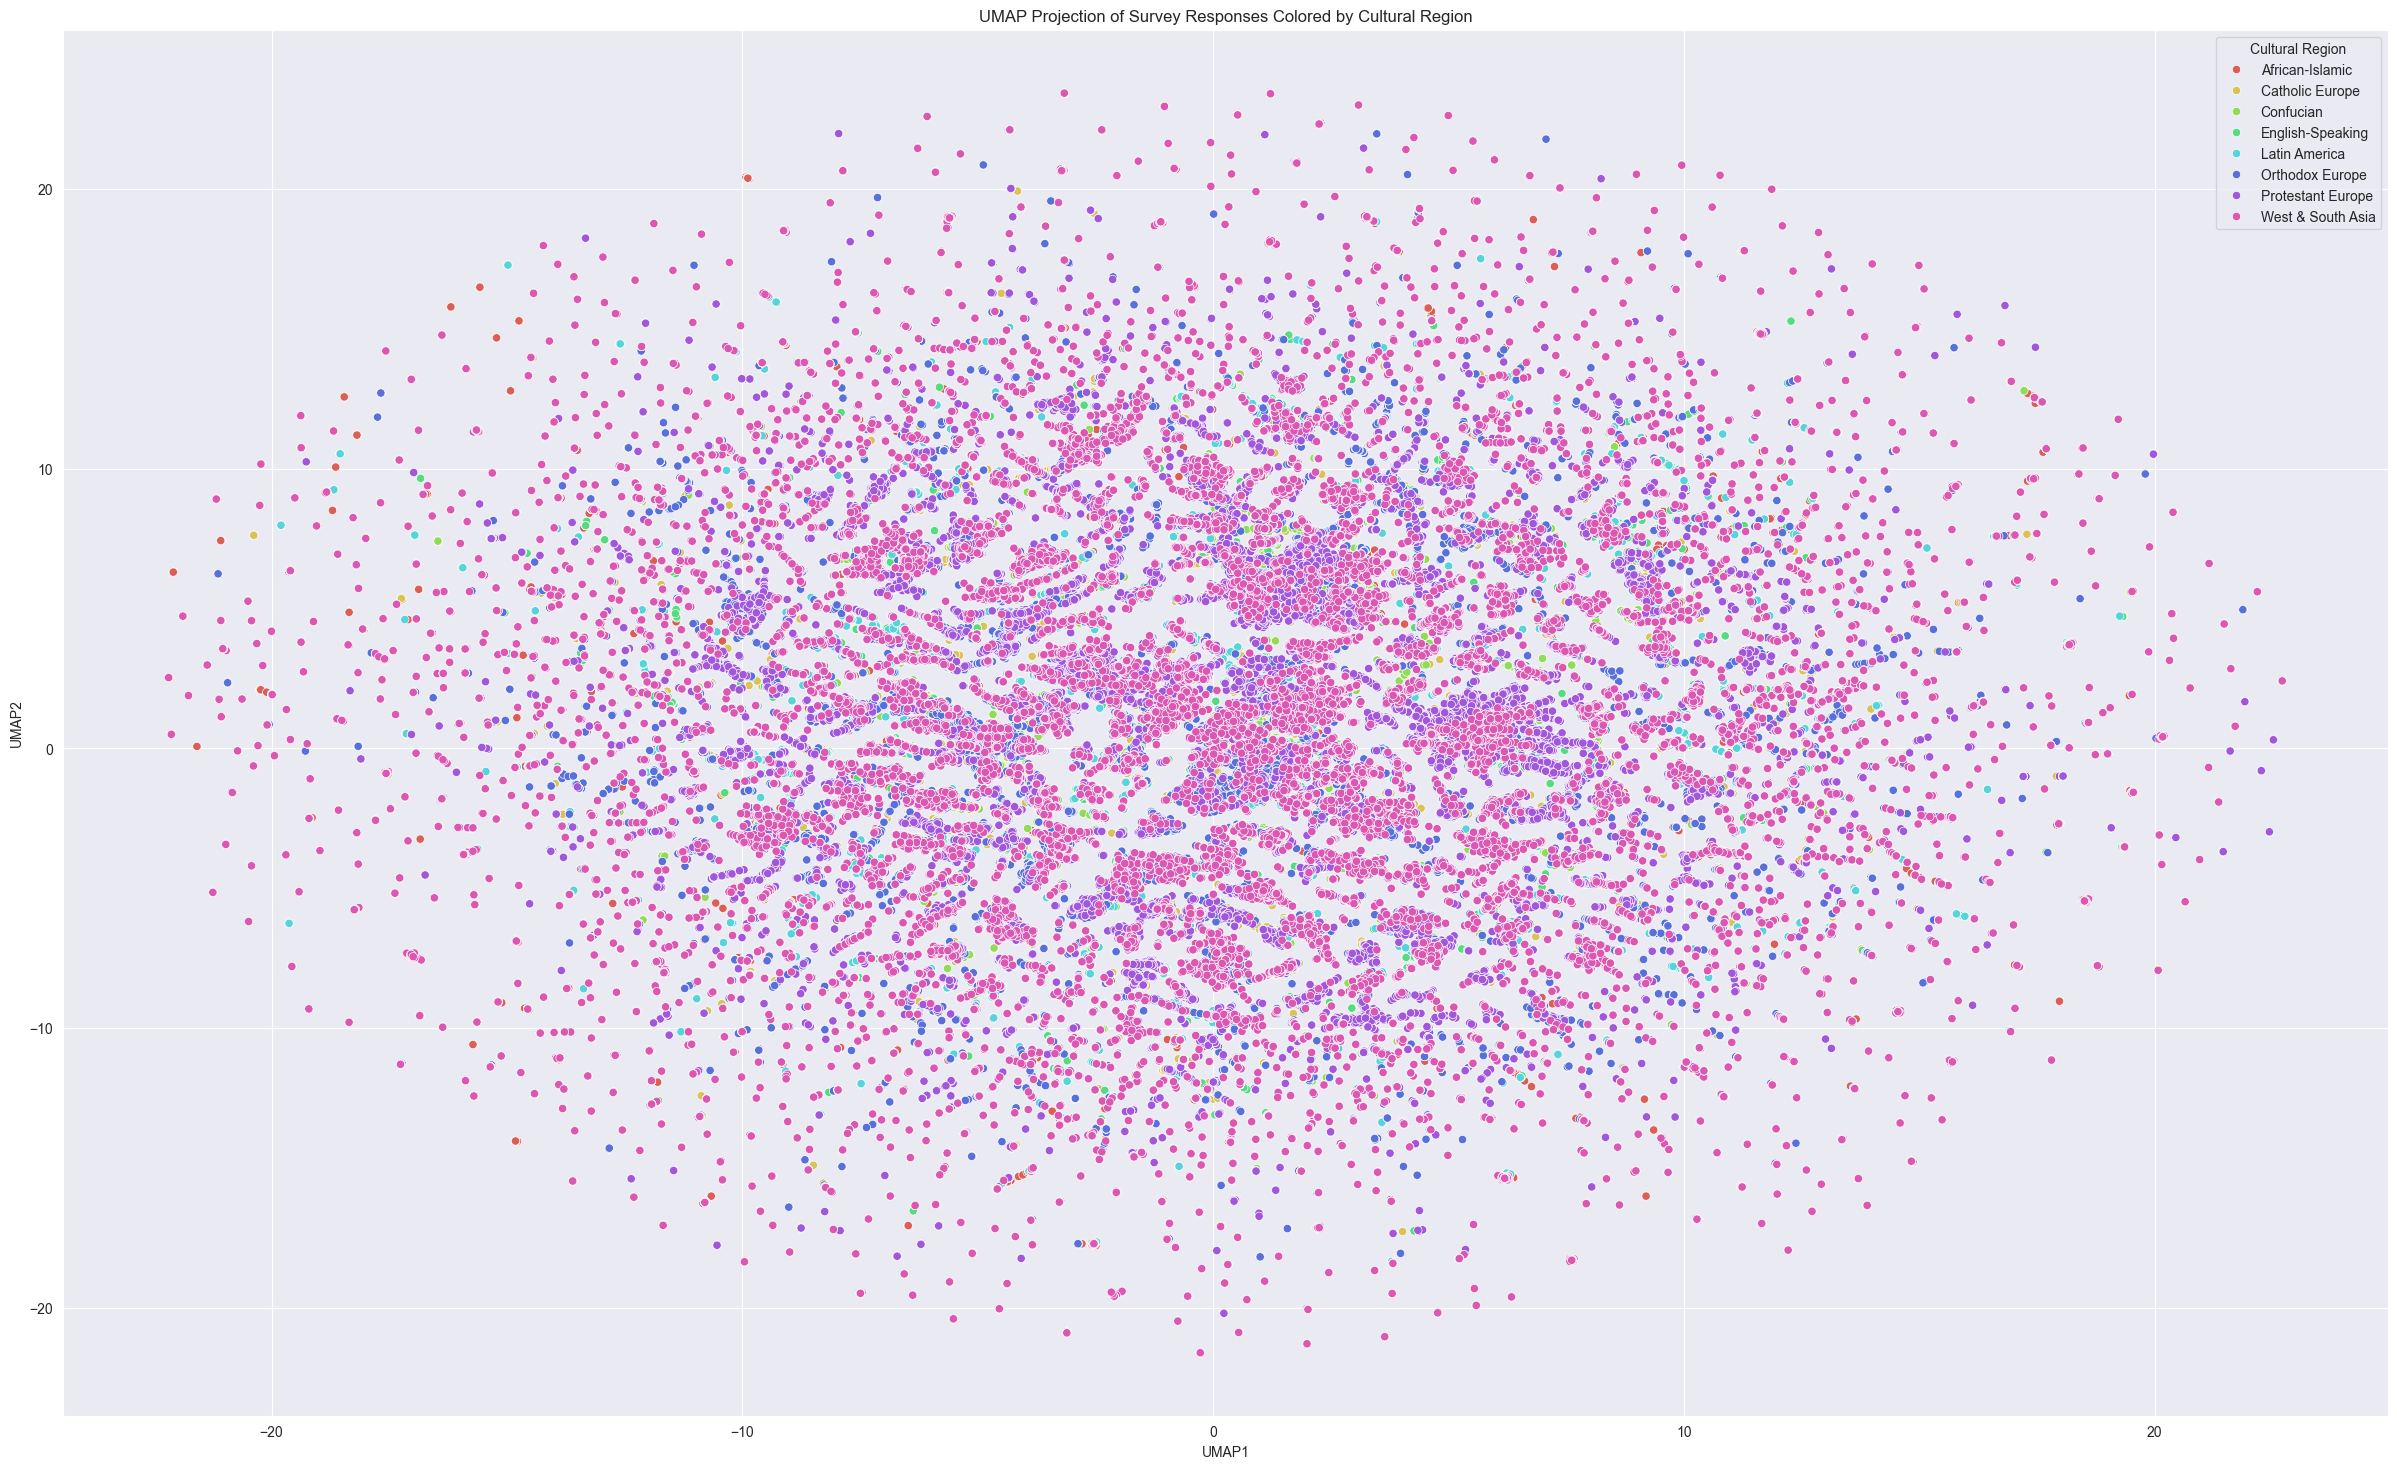

In [24]:
plt.figure(figsize=(30, 18))
sns.scatterplot(data=embedding_df, x="UMAP1", y="UMAP2", hue="Cultural Region", palette="hls")
plt.title("UMAP Projection of Survey Responses Colored by Cultural Region")
plt.show()

In [25]:
# Calculate the mean of the rescaled individual-level scores for each country
country_scores_umap = embedding_df.groupby('Country')[['UMAP1', 'UMAP2']].mean().reset_index()

In [26]:
# Merge back the cultural region and Islamic columns
country_scores_umap = country_scores_umap.merge(country_codes[['Country', 'Cultural Region', 'Islamic']], on='Country', how='left')

# Mapping cultural regions to colors
cultural_region_colors = {
    'African-Islamic': 'black',
    'Confucian': 'deepskyblue',
    'Latin America': 'violet',
    'Protestant Europe': 'orange',
    'Catholic Europe': 'gold',
    'English-Speaking': 'green',
    'Orthodox Europe': 'blue',
    'West & South Asia': 'brown'
}


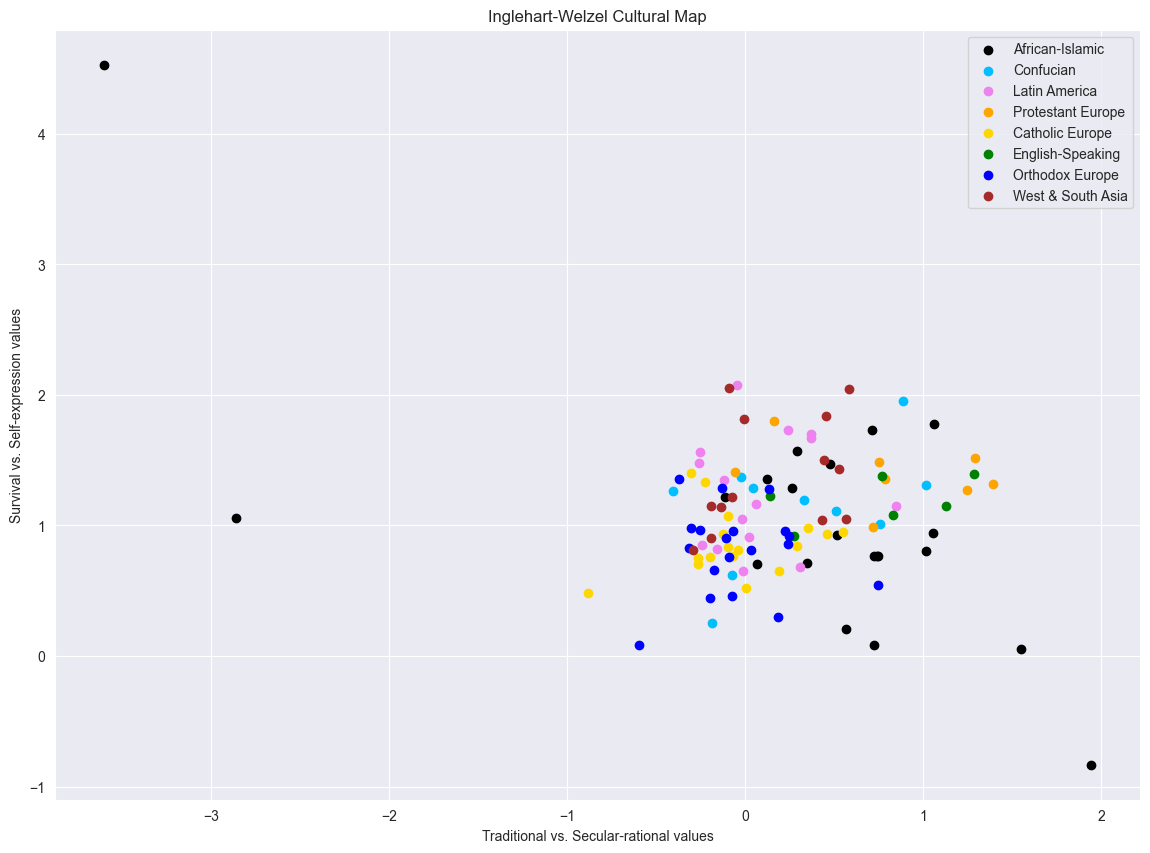

In [28]:
# Plot the Cultural Map
plt.figure(figsize=(14, 10))


# Create a scatter plot with colored points based on cultural regions
for region, color in cultural_region_colors.items():
    subset = country_scores_umap[country_scores_umap['Cultural Region'] == region]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], label=region, color=color)

plt.xlabel('Traditional vs. Secular-rational values')
plt.ylabel('Survival vs. Self-expression values')
plt.title('Inglehart-Welzel Cultural Map')

# Add legend
plt.legend()

plt.grid(True)
plt.show()

In [29]:
country_scores_umap

,Country,UMAP1,UMAP2,Cultural Region,Islamic
0,Albania,-0.596213,0.081168,Orthodox Europe,True
1,Algeria,0.515692,0.926583,African-Islamic,True
2,Andorra,0.294834,0.840714,Catholic Europe,False
3,Argentina,0.020383,0.910202,Latin America,False
4,Armenia,-0.069178,0.954109,Orthodox Europe,False
...,...,...,...,...,...
104,Venezuela (Bolivarian Republic of),0.309311,0.682402,Latin America,False
105,Viet Nam,-0.187672,0.252721,Confucian,False
106,Yemen,0.748735,0.770007,African-Islamic,True
107,Zambia,0.739985,0.763597,African-Islamic,True


In [34]:
x = country_scores_umap.dropna()['UMAP1']
y = country_scores_umap.dropna()['UMAP2']
categories = country_scores_umap.dropna()['Cultural Region']
# create number map for categories
categories = pd.Categorical(categories)
categories = categories.codes
categories

array([5, 0, 1, 4, 5, 3, 1, 5, 7, 5, 1, 4, 5, 4, 5, 0, 3, 4, 2, 4, 1, 1,
       1, 6, 4, 0, 5, 0, 6, 1, 5, 6, 0, 5, 4, 4, 2, 1, 6, 7, 7, 7, 0, 1,
       1, 2, 0, 5, 0, 2, 0, 7, 5, 0, 0, 5, 1, 2, 7, 7, 0, 1, 4, 5, 2, 5,
       0, 7, 6, 3, 4, 0, 6, 7, 0, 4, 7, 1, 1, 4, 0, 5, 5, 5, 0, 5, 2, 1,
       1, 3, 1, 6, 6, 2, 7, 2, 4, 0, 7, 5, 3, 3, 4, 7, 4, 2, 0, 0, 0],
      dtype=int8)

In [35]:
data = np.column_stack((x, y)).astype(float)
labels = np.array(categories).astype(int)

In [36]:
from sklearn.svm import SVC

# Create an SVM classifier with a radial basis function kernel
svm_classifier = SVC(kernel='rbf', gamma='auto')

# Fit the classifier to the data
svm_classifier.fit(data, labels)

SVC(gamma='auto')

C:\Users\shavh\AppData\Local\Temp\ipykernel_8536\1658699202.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(np.unique(labels)))


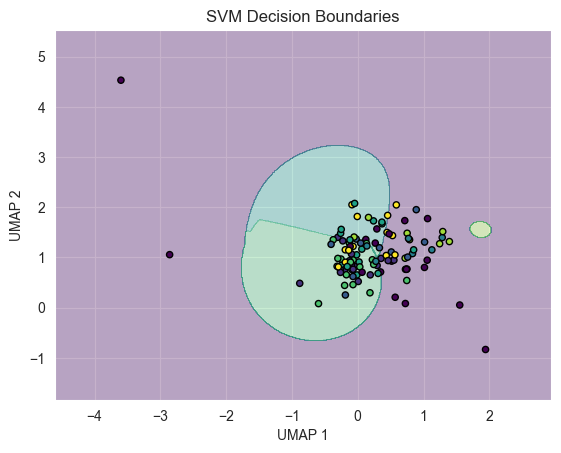

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a mesh grid
h = .01  # step size in the mesh
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict classifications for each point in the mesh
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define color map
cmap = plt.cm.get_cmap('viridis', len(np.unique(labels)))
norm = mcolors.BoundaryNorm(np.arange(-0.5, len(np.unique(labels)), 1), cmap.N)

# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3, norm=norm)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=cmap, edgecolors='k', s=20)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('SVM Decision Boundaries')
plt.show()
